In [1]:
from datasets import load_from_disk
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os
import torch
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../../../")
import calibration_ppd as cppd

In [17]:
def read_cbow_results():
    results_path = "../results/basic_training/"
    data = {}
    for split in os.listdir(os.path.join(results_path,"cache/00_Load Quora Dataset/")):
        data[split] = load_from_disk(os.path.join(results_path,"cache/00_Load Quora Dataset/",split))
    twitter_data = load_from_disk(os.path.join(results_path,"cache/01_Load Twitter Dataset/"))
    data["qqp_test"] = data.pop("test")
    data["twitter_test"] = twitter_data
    tokenizer = AutoTokenizer.from_pretrained(os.path.join(results_path,"cache/02_Load tokenizer/"))
    state_dict = torch.load(os.path.join(results_path,"run00_cbow/08_Train model/state_dict.pkl"))
    with open(os.path.join(results_path,"run00_cbow/06_Init Model/config.json"),"r") as f:
        config = json.load(f)
        name = config.pop("name")
    model_cls = getattr(cppd,name)
    model = model_cls(**config)
    model.load_state_dict(state_dict)
    with open(os.path.join(results_path,"run00_cbow/09_Evaluation of the model/results.pkl"),"rb") as f:
        predictions = pickle.load(f)

    return data, tokenizer, model, predictions

def read_bert_results():
    results_path = "../results/basic_training/"
    data = {}
    for split in os.listdir(os.path.join(results_path,"cache/00_Load Quora Dataset/")):
        data[split] = load_from_disk(os.path.join(results_path,"cache/00_Load Quora Dataset/",split))
    twitter_data = load_from_disk(os.path.join(results_path,"cache/01_Load Twitter Dataset/"))
    data["qqp_test"] = data.pop("test")
    data["twitter_test"] = twitter_data
    tokenizer = AutoTokenizer.from_pretrained(os.path.join(results_path,"cache/02_Load tokenizer/"))
    state_dict = torch.load(os.path.join(results_path,"run01_bert/08_Train model/state_dict.pkl"))
    model = AutoModelForSequenceClassification.from_pretrained(os.path.join(results_path,"run01_bert/06_Init Model/"))
    model.load_state_dict(state_dict)
    with open(os.path.join(results_path,"run01_bert/09_Evaluation of the model/results.pkl"),"rb") as f:
        predictions = pickle.load(f)

    return data, tokenizer, model, predictions

model_name = "bert"
if model_name == "bert":
    data, tokenizer, model, predictions = read_bert_results()
elif model_name == "cbow":
    data, tokenizer, model, predictions = read_cbow_results()

In [25]:
def calculate_priors(test="qqp"):
    counts = np.bincount(predictions[f"{test}_test"]["labels"])
    priors = counts / counts.sum()
    return priors
calculate_priors("twitter")

array([0.8048048, 0.1951952])

In [18]:
trh = 0.5
for split, results in predictions.items():
    labels = results["labels"]
    logits = results["logits"]
    preds = (logits > trh).astype(float)
    acc = np.mean(preds == labels)
    print(f"Accuracy on {split} split: {acc:.04f}")

Accuracy on model_train split: 0.9287
Accuracy on calibration_train split: 0.8943
Accuracy on validation split: 0.8928
Accuracy on qqp_test split: 0.8909
Accuracy on twitter_test split: 0.8633


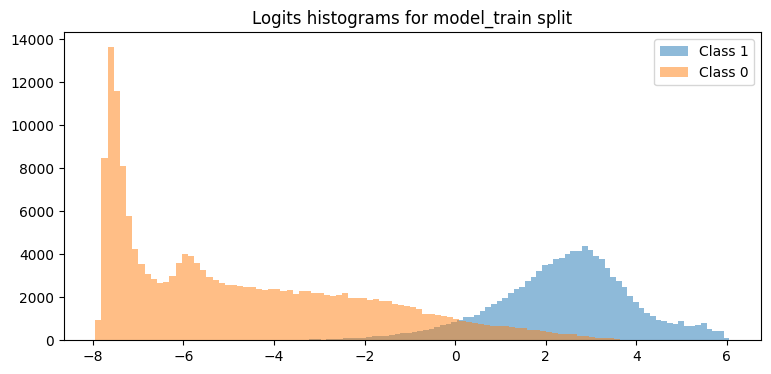

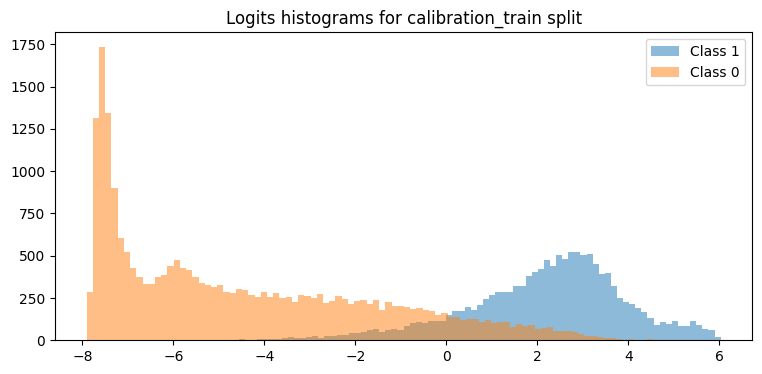

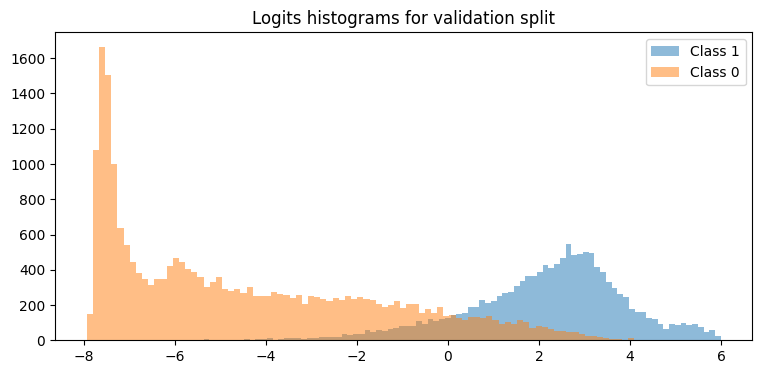

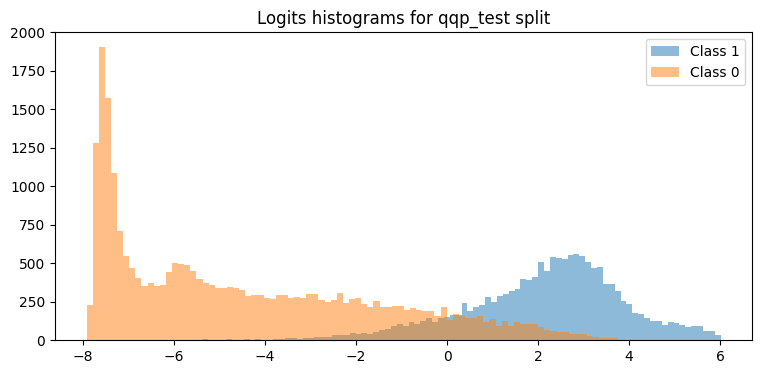

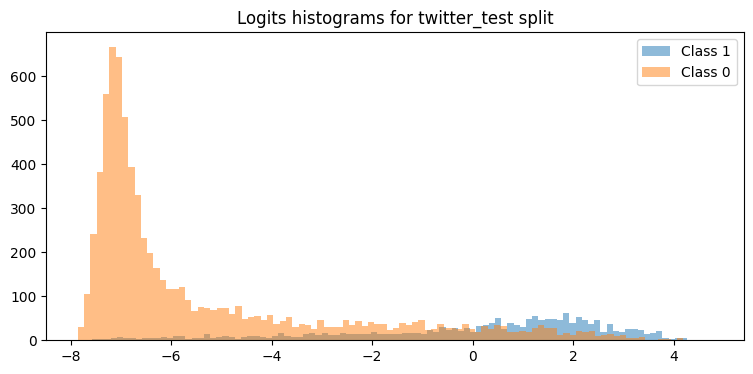

In [19]:
for split, results in predictions.items():
    labels = results["labels"]
    logits = results["logits"]
    logits_class1 = logits[labels == 1]
    logits_class0 = logits[labels == 0]

    fig, ax = plt.subplots(1,1,figsize=(9,4))
    ax.hist(logits_class1,bins=100,alpha=0.5,label="Class 1")
    ax.hist(logits_class0,bins=100,alpha=0.5,label="Class 0")
    ax.legend()
    ax.set_title(f"Logits histograms for {split} split")

